# Лабораторная работа № 1

In [ ]:
!pip install pandas requests pyod openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=cb902209452831d9479bdb649e83c36507ec9ea4c9c8ae71d92d9a7f4d4fff22
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
import pandas as pd
import requests
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns

from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.utils.data import get_outliers_inliers
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

In [ ]:
# скачивание данных
def get_vacancies(keyword, only_with_salary=True, pages=20, per_page=100):
    vacancies = []
    for page in range(pages):
        params = {
            'text': keyword,
            'only_with_salary': 'true' if only_with_salary else 'false',
            'page': page,
            'per_page': per_page
        }
        response = requests.get('https://api.hh.ru/vacancies', params=params)
        if response.status_code == 200:
            data = response.json()
            vacancies.extend(data.get('items', []))
            print(f'Страница {page + 1} получена. Всего вакансий: {len(vacancies)}')
            time.sleep(0.5)
        else:
            print(f'Ошибка при запросе страницы {page + 1}: {response.status_code}')
            break
    return vacancies

keyword = 'Разработчик'
vacancies = get_vacancies(keyword)

Страница 1 получена. Всего вакансий: 100
Страница 2 получена. Всего вакансий: 200
Страница 3 получена. Всего вакансий: 300
Страница 4 получена. Всего вакансий: 400
Страница 5 получена. Всего вакансий: 500
Страница 6 получена. Всего вакансий: 600
Страница 7 получена. Всего вакансий: 700
Страница 8 получена. Всего вакансий: 800
Страница 9 получена. Всего вакансий: 900
Страница 10 получена. Всего вакансий: 1000
Страница 11 получена. Всего вакансий: 1100
Страница 12 получена. Всего вакансий: 1200
Страница 13 получена. Всего вакансий: 1300
Страница 14 получена. Всего вакансий: 1400
Страница 15 получена. Всего вакансий: 1500
Страница 16 получена. Всего вакансий: 1600
Страница 17 получена. Всего вакансий: 1700
Страница 18 получена. Всего вакансий: 1800
Страница 19 получена. Всего вакансий: 1900
Страница 20 получена. Всего вакансий: 2000


In [ ]:
def extract_vacancy_data(vacancy):
    return {
        'id': vacancy.get('id'),
        'name': vacancy.get('name'),
        'area.name': vacancy.get('area', {}).get('name'),
        'salary.from': vacancy.get('salary', {}).get('from'),
        'salary.to': vacancy.get('salary', {}).get('to'),
        'salary.gross': vacancy.get('salary', {}).get('gross'),
        'salary.currency': vacancy.get('salary', {}).get('currency'),
        'snippet.requirements': vacancy.get('snippet', {}).get('requirements'),
        'experience.name': vacancy.get('experience', {}).get('name')
    }

df = pd.DataFrame([extract_vacancy_data(vac) for vac in vacancies])
df

,id,name,area.name,salary.from,salary.to,salary.gross,salary.currency,snippet.requirements,experience.name
0,113847165,Заместитель Генерального директора,Астана,600000.0,800000.0,True,KZT,None,Более 6 лет
1,113871977,Chief Executive officer (CEO),Ташкент,2000.0,5000.0,False,EUR,None,Более 6 лет
2,113759457,Шеф-повар,Ташкент,15000000.0,NaN,False,UZS,None,От 1 года до 3 лет
3,112835059,Backend-разработчик Python (Junior+),Бердск,55000.0,NaN,False,RUR,None,Нет опыта
4,113872464,Chief Executive officer (CEO),Алматы,2000.0,5000.0,False,EUR,None,Более 6 лет
...,...,...,...,...,...,...,...,...,...
1995,108462859,Начинающий специалист в IT компанию в чате (ночь),Москва,60000.0,70000.0,False,RUR,None,Нет опыта
1996,111974253,Amazon PPC Manager/Project Manager,Тбилиси,1000.0,1500.0,False,USD,None,От 1 года до 3 лет
1997,112477744,Sales Manager (real estate),Индонезия,2000.0,5000.0,True,USD,None,От 1 года до 3 лет
1998,112731515,Младший проект-менеджер в IT,Самара,40000.0,50000.0,True,RUR,None,Нет опыта


In [ ]:
# создание clean_sal
def calculate_clean_salary(row):
    if pd.notnull(row['salary.from']) and pd.notnull(row['salary.to']):
        return (row['salary.from'] + row['salary.to']) / 2
    elif pd.notnull(row['salary.from']):
        return row['salary.from']
    elif pd.notnull(row['salary.to']):
        return row['salary.to']
    else:
        return None

df['clean_sal'] = df.apply(calculate_clean_salary, axis=1)
df = df.dropna(subset=['clean_sal'])
df

,id,name,area.name,salary.from,salary.to,salary.gross,salary.currency,snippet.requirements,experience.name,clean_sal
0,113847165,Заместитель Генерального директора,Астана,600000.0,800000.0,True,KZT,None,Более 6 лет,700000.0
1,113871977,Chief Executive officer (CEO),Ташкент,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0
2,113759457,Шеф-повар,Ташкент,15000000.0,NaN,False,UZS,None,От 1 года до 3 лет,15000000.0
3,112835059,Backend-разработчик Python (Junior+),Бердск,55000.0,NaN,False,RUR,None,Нет опыта,55000.0
4,113872464,Chief Executive officer (CEO),Алматы,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0
...,...,...,...,...,...,...,...,...,...,...
1995,108462859,Начинающий специалист в IT компанию в чате (ночь),Москва,60000.0,70000.0,False,RUR,None,Нет опыта,65000.0
1996,111974253,Amazon PPC Manager/Project Manager,Тбилиси,1000.0,1500.0,False,USD,None,От 1 года до 3 лет,1250.0
1997,112477744,Sales Manager (real estate),Индонезия,2000.0,5000.0,True,USD,None,От 1 года до 3 лет,3500.0
1998,112731515,Младший проект-менеджер в IT,Самара,40000.0,50000.0,True,RUR,None,Нет опыта,45000.0


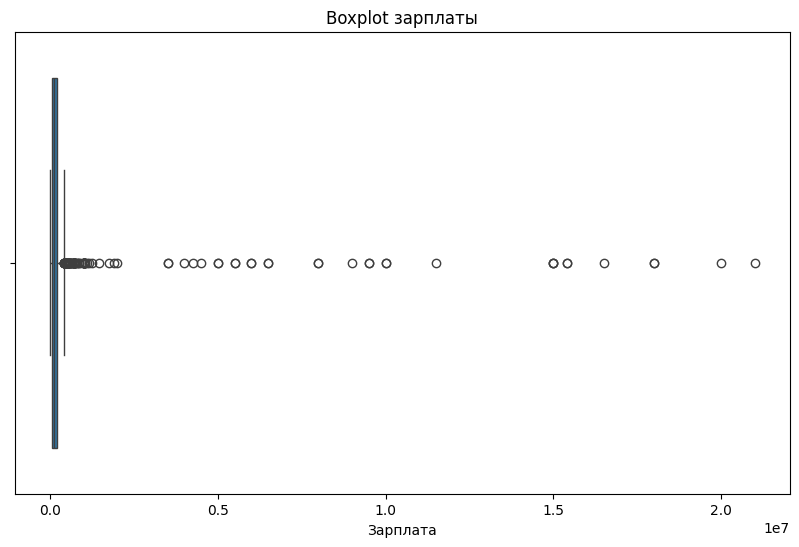

In [ ]:
# аномалии
plt.figure(figsize=(10,6))
sns.boxplot(x=df['clean_sal'])
plt.title('Boxplot зарплаты')
plt.xlabel('Зарплата')
plt.show()

In [ ]:
# масштабирование данных
scaler = StandardScaler()
X = scaler.fit_transform(df[['clean_sal']])

In [ ]:
# iforest

model_iforest = IForest()
model_iforest.fit(X)
df['anomaly1'] = model_iforest.predict(X)  # 0: нормальные, 1: аномалии
df

,id,name,area.name,salary.from,salary.to,salary.gross,salary.currency,snippet.requirements,experience.name,clean_sal,anomaly1
0,113847165,Заместитель Генерального директора,Астана,600000.0,800000.0,True,KZT,None,Более 6 лет,700000.0,1
1,113871977,Chief Executive officer (CEO),Ташкент,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0
2,113759457,Шеф-повар,Ташкент,15000000.0,NaN,False,UZS,None,От 1 года до 3 лет,15000000.0,1
3,112835059,Backend-разработчик Python (Junior+),Бердск,55000.0,NaN,False,RUR,None,Нет опыта,55000.0,0
4,113872464,Chief Executive officer (CEO),Алматы,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,108462859,Начинающий специалист в IT компанию в чате (ночь),Москва,60000.0,70000.0,False,RUR,None,Нет опыта,65000.0,0
1996,111974253,Amazon PPC Manager/Project Manager,Тбилиси,1000.0,1500.0,False,USD,None,От 1 года до 3 лет,1250.0,0
1997,112477744,Sales Manager (real estate),Индонезия,2000.0,5000.0,True,USD,None,От 1 года до 3 лет,3500.0,0
1998,112731515,Младший проект-менеджер в IT,Самара,40000.0,50000.0,True,RUR,None,Нет опыта,45000.0,0


In [ ]:
# knn

model_knn = KNN()
model_knn.fit(X)
df['anomaly2'] = model_knn.predict(X)
df

,id,name,area.name,salary.from,salary.to,salary.gross,salary.currency,snippet.requirements,experience.name,clean_sal,anomaly1,anomaly2
0,113847165,Заместитель Генерального директора,Астана,600000.0,800000.0,True,KZT,None,Более 6 лет,700000.0,1,0
1,113871977,Chief Executive officer (CEO),Ташкент,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0,0
2,113759457,Шеф-повар,Ташкент,15000000.0,NaN,False,UZS,None,От 1 года до 3 лет,15000000.0,1,1
3,112835059,Backend-разработчик Python (Junior+),Бердск,55000.0,NaN,False,RUR,None,Нет опыта,55000.0,0,0
4,113872464,Chief Executive officer (CEO),Алматы,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,108462859,Начинающий специалист в IT компанию в чате (ночь),Москва,60000.0,70000.0,False,RUR,None,Нет опыта,65000.0,0,0
1996,111974253,Amazon PPC Manager/Project Manager,Тбилиси,1000.0,1500.0,False,USD,None,От 1 года до 3 лет,1250.0,0,0
1997,112477744,Sales Manager (real estate),Индонезия,2000.0,5000.0,True,USD,None,От 1 года до 3 лет,3500.0,0,0
1998,112731515,Младший проект-менеджер в IT,Самара,40000.0,50000.0,True,RUR,None,Нет опыта,45000.0,0,0


In [ ]:
# autoEncoder

model_ae = AutoEncoder()
model_ae.fit(X)
df['anomaly3'] = model_ae.predict(X)
df

Training: 100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


,id,name,area.name,salary.from,salary.to,salary.gross,salary.currency,snippet.requirements,experience.name,clean_sal,anomaly1,anomaly2,anomaly3
0,113847165,Заместитель Генерального директора,Астана,600000.0,800000.0,True,KZT,None,Более 6 лет,700000.0,1,0,1
1,113871977,Chief Executive officer (CEO),Ташкент,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0,0,0
2,113759457,Шеф-повар,Ташкент,15000000.0,NaN,False,UZS,None,От 1 года до 3 лет,15000000.0,1,1,1
3,112835059,Backend-разработчик Python (Junior+),Бердск,55000.0,NaN,False,RUR,None,Нет опыта,55000.0,0,0,0
4,113872464,Chief Executive officer (CEO),Алматы,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,108462859,Начинающий специалист в IT компанию в чате (ночь),Москва,60000.0,70000.0,False,RUR,None,Нет опыта,65000.0,0,0,0
1996,111974253,Amazon PPC Manager/Project Manager,Тбилиси,1000.0,1500.0,False,USD,None,От 1 года до 3 лет,1250.0,0,0,0
1997,112477744,Sales Manager (real estate),Индонезия,2000.0,5000.0,True,USD,None,От 1 года до 3 лет,3500.0,0,0,0
1998,112731515,Младший проект-менеджер в IT,Самара,40000.0,50000.0,True,RUR,None,Нет опыта,45000.0,0,0,0


In [ ]:
# голосование большинством
def majority_vote(row):
    votes = row[['anomaly1', 'anomaly2', 'anomaly3']].tolist()
    return 1 if votes.count(1) >= 2 else 0

df['anomaly'] = df.apply(majority_vote, axis=1)
df

,id,name,area.name,salary.from,salary.to,salary.gross,salary.currency,snippet.requirements,experience.name,clean_sal,anomaly1,anomaly2,anomaly3,anomaly
0,113847165,Заместитель Генерального директора,Астана,600000.0,800000.0,True,KZT,None,Более 6 лет,700000.0,1,0,1,1
1,113871977,Chief Executive officer (CEO),Ташкент,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0,0,0,0
2,113759457,Шеф-повар,Ташкент,15000000.0,NaN,False,UZS,None,От 1 года до 3 лет,15000000.0,1,1,1,1
3,112835059,Backend-разработчик Python (Junior+),Бердск,55000.0,NaN,False,RUR,None,Нет опыта,55000.0,0,0,0,0
4,113872464,Chief Executive officer (CEO),Алматы,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,108462859,Начинающий специалист в IT компанию в чате (ночь),Москва,60000.0,70000.0,False,RUR,None,Нет опыта,65000.0,0,0,0,0
1996,111974253,Amazon PPC Manager/Project Manager,Тбилиси,1000.0,1500.0,False,USD,None,От 1 года до 3 лет,1250.0,0,0,0,0
1997,112477744,Sales Manager (real estate),Индонезия,2000.0,5000.0,True,USD,None,От 1 года до 3 лет,3500.0,0,0,0,0
1998,112731515,Младший проект-менеджер в IT,Самара,40000.0,50000.0,True,RUR,None,Нет опыта,45000.0,0,0,0,0


In [ ]:
# информация про аномалии
def explain_anomaly(row):
    explanations = []
    if row['anomaly1'] == 1:
        explanations.append('Высокая зарплата')
    if row['anomaly2'] == 1:
        explanations.append('Низкая зарплата')
    if row['anomaly3'] == 1:
        explanations.append('Необычные требования')
    return '; '.join(explanations) if explanations else 'Нет аномалий'

df['anomaly_explanation'] = df.apply(explain_anomaly, axis=1)
df

,id,name,area.name,salary.from,salary.to,salary.gross,salary.currency,snippet.requirements,experience.name,clean_sal,anomaly1,anomaly2,anomaly3,anomaly,anomaly_explanation
0,113847165,Заместитель Генерального директора,Астана,600000.0,800000.0,True,KZT,None,Более 6 лет,700000.0,1,0,1,1,Высокая зарплата; Необычные требования
1,113871977,Chief Executive officer (CEO),Ташкент,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0,0,0,0,Нет аномалий
2,113759457,Шеф-повар,Ташкент,15000000.0,NaN,False,UZS,None,От 1 года до 3 лет,15000000.0,1,1,1,1,Высокая зарплата; Низкая зарплата; Необычные т...
3,112835059,Backend-разработчик Python (Junior+),Бердск,55000.0,NaN,False,RUR,None,Нет опыта,55000.0,0,0,0,0,Нет аномалий
4,113872464,Chief Executive officer (CEO),Алматы,2000.0,5000.0,False,EUR,None,Более 6 лет,3500.0,0,0,0,0,Нет аномалий
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,108462859,Начинающий специалист в IT компанию в чате (ночь),Москва,60000.0,70000.0,False,RUR,None,Нет опыта,65000.0,0,0,0,0,Нет аномалий
1996,111974253,Amazon PPC Manager/Project Manager,Тбилиси,1000.0,1500.0,False,USD,None,От 1 года до 3 лет,1250.0,0,0,0,0,Нет аномалий
1997,112477744,Sales Manager (real estate),Индонезия,2000.0,5000.0,True,USD,None,От 1 года до 3 лет,3500.0,0,0,0,0,Нет аномалий
1998,112731515,Младший проект-менеджер в IT,Самара,40000.0,50000.0,True,RUR,None,Нет опыта,45000.0,0,0,0,0,Нет аномалий


In [ ]:
df.to_excel('vacancies_analyzed.xlsx', index=False)